# **Instead of performing a multiclass classification, a binary classification was performed twice and the results were analyzed.**

In [1]:
%%time

SEED=42

import numpy as np
import pandas as pd
from sklearn import preprocessing
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.neighbors import LocalOutlierFactor
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, KFold,cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.metrics import roc_curve, classification_report, confusion_matrix
from sklearn.metrics import f1_score, make_scorer

from scipy import stats

import seaborn as sns
import matplotlib.pyplot as plt

CPU times: user 1.87 s, sys: 832 ms, total: 2.71 s
Wall time: 1.42 s


In [2]:
sample_submission = pd.read_csv('data/sample_submission.csv')
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

sample_submission.shape, train.shape, test.shape

((824, 2), (1235, 29), (824, 28))

In [3]:
train

,id,surgery,age,hospital_number,rectal_temp,pulse,respiratory_rate,temp_of_extremities,peripheral_pulse,mucous_membrane,...,packed_cell_volume,total_protein,abdomo_appearance,abdomo_protein,surgical_lesion,lesion_1,lesion_2,lesion_3,cp_data,outcome
0,0,yes,adult,530001,38.1,132.0,24.0,cool,reduced,dark_cyanotic,...,57.0,8.5,serosanguious,3.4,yes,2209,0,0,no,died
1,1,yes,adult,533836,37.5,88.0,12.0,cool,normal,pale_cyanotic,...,33.0,64.0,serosanguious,2.0,yes,2208,0,0,no,euthanized
2,2,yes,adult,529812,38.3,120.0,28.0,cool,reduced,pale_pink,...,37.0,6.4,serosanguious,3.4,yes,5124,0,0,no,lived
3,3,yes,adult,5262541,37.1,72.0,30.0,cold,reduced,pale_pink,...,53.0,7.0,cloudy,3.9,yes,2208,0,0,yes,lived
4,4,no,adult,5299629,38.0,52.0,48.0,normal,normal,normal_pink,...,47.0,7.3,cloudy,2.6,no,0,0,0,yes,lived
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1230,1230,yes,adult,535246,38.5,129.0,48.0,cool,reduced,pale_pink,...,57.0,66.0,serosanguious,2.0,yes,2206,0,0,no,lived
1231,1231,yes,adult,528570,37.5,60.0,50.0,cool,reduced,pale_cyanotic,...,35.0,6.4,serosanguious,3.6,yes,2209,0,0,yes,died
1232,1232,yes,young,529685,37.5,84.0,40.0,normal,reduced,normal_pink,...,40.0,5.9,cloudy,7.0,yes,400,0,0,yes,lived
1233,1233,yes,adult,534784,38.1,70.0,16.0,normal,reduced,bright_red,...,58.0,74.0,cloudy,2.0,yes,2209,0,0,no,lived


In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1235 entries, 0 to 1234
Data columns (total 29 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     1235 non-null   int64  
 1   surgery                1235 non-null   object 
 2   age                    1235 non-null   object 
 3   hospital_number        1235 non-null   int64  
 4   rectal_temp            1235 non-null   float64
 5   pulse                  1235 non-null   float64
 6   respiratory_rate       1235 non-null   float64
 7   temp_of_extremities    1196 non-null   object 
 8   peripheral_pulse       1175 non-null   object 
 9   mucous_membrane        1214 non-null   object 
 10  capillary_refill_time  1229 non-null   object 
 11  pain                   1191 non-null   object 
 12  peristalsis            1215 non-null   object 
 13  abdominal_distention   1212 non-null   object 
 14  nasogastric_tube       1155 non-null   object 
 15  naso

In [5]:
train['outcome'].value_counts()

outcome
lived         574
died          410
euthanized    251
Name: count, dtype: int64

In [6]:
train_2 = train[train['outcome']!='lived']
train_2.shape

(661, 29)

In [7]:
le = preprocessing.LabelEncoder()
object_columns = train.select_dtypes(include='object').columns

for i in object_columns[0:-1]:
    labels = train[i]
    labels_id = le.fit_transform(labels)
    train[i] = labels_id

train

,id,surgery,age,hospital_number,rectal_temp,pulse,respiratory_rate,temp_of_extremities,peripheral_pulse,mucous_membrane,...,packed_cell_volume,total_protein,abdomo_appearance,abdomo_protein,surgical_lesion,lesion_1,lesion_2,lesion_3,cp_data,outcome
0,0,1,0,530001,38.1,132.0,24.0,1,3,2,...,57.0,8.5,2,3.4,1,2209,0,0,0,died
1,1,1,0,533836,37.5,88.0,12.0,1,2,4,...,33.0,64.0,2,2.0,1,2208,0,0,0,euthanized
2,2,1,0,529812,38.3,120.0,28.0,1,3,5,...,37.0,6.4,2,3.4,1,5124,0,0,0,lived
3,3,1,0,5262541,37.1,72.0,30.0,0,3,5,...,53.0,7.0,1,3.9,1,2208,0,0,1,lived
4,4,0,0,5299629,38.0,52.0,48.0,2,2,3,...,47.0,7.3,1,2.6,0,0,0,0,1,lived
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1230,1230,1,0,535246,38.5,129.0,48.0,1,3,5,...,57.0,66.0,2,2.0,1,2206,0,0,0,lived
1231,1231,1,0,528570,37.5,60.0,50.0,1,3,4,...,35.0,6.4,2,3.6,1,2209,0,0,1,died
1232,1232,1,1,529685,37.5,84.0,40.0,2,3,3,...,40.0,5.9,1,7.0,1,400,0,0,1,lived
1233,1233,1,0,534784,38.1,70.0,16.0,2,3,1,...,58.0,74.0,1,2.0,1,2209,0,0,0,lived


In [8]:
object_columns_test = test.select_dtypes(include='object').columns

for i in object_columns_test:
    labels = test[i]
    labels_id = le.fit_transform(labels)
    test[i] = labels_id

test

,id,surgery,age,hospital_number,rectal_temp,pulse,respiratory_rate,temp_of_extremities,peripheral_pulse,mucous_membrane,...,abdomen,packed_cell_volume,total_protein,abdomo_appearance,abdomo_protein,surgical_lesion,lesion_1,lesion_2,lesion_3,cp_data
0,1235,0,0,534053,38.6,40.0,20.0,2,2,3,...,1,42.0,7.5,0,2.3,0,0,0,0,0
1,1236,1,0,528469,38.2,112.0,48.0,1,3,0,...,1,44.0,6.0,2,2.6,0,2208,0,0,1
2,1237,1,0,528178,37.7,66.0,12.0,1,2,1,...,1,31.5,6.0,1,1.6,1,2205,0,0,1
3,1238,0,0,534784,37.1,88.0,20.0,1,3,4,...,0,75.0,81.0,3,1.0,1,1400,0,0,0
4,1239,1,0,529840,38.3,50.0,12.0,4,2,0,...,1,37.0,6.8,1,2.6,1,2208,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
819,2054,0,0,529461,40.3,114.0,36.0,1,3,3,...,0,57.0,8.1,2,4.5,1,3205,0,0,1
820,2055,1,0,535338,37.2,100.0,20.0,1,3,4,...,1,50.0,66.0,2,2.0,1,2209,0,0,0
821,2056,1,0,529640,39.2,132.0,12.0,1,3,2,...,5,53.0,7.6,2,4.5,1,2205,0,0,0
822,2057,0,0,5287179,38.3,54.0,66.0,2,2,3,...,5,49.0,8.6,0,5.0,0,3111,0,0,1


In [9]:
# Imputation
imp_mean = IterativeImputer(random_state=SEED)
Imp_X= imp_mean.fit_transform(train.iloc[:,1:-1])

In [10]:
# Outlier removal
local_outlier_factor = LocalOutlierFactor(contamination='auto', novelty=True)
local_outlier_factor.fit(Imp_X)
predicted = local_outlier_factor.predict(Imp_X)

In [11]:
IX = pd.DataFrame(Imp_X)
IX.index = train.iloc[:,1:-1].index
IX.columns = train.iloc[:,1:-1].columns

pd.DataFrame(predicted).value_counts()
X = IX.loc[predicted > 0,:]
y = train.iloc[:,-1].loc[predicted > 0]

In [12]:
TRAIN = pd.concat([X,y],axis=1)
TRAIN

,surgery,age,hospital_number,rectal_temp,pulse,respiratory_rate,temp_of_extremities,peripheral_pulse,mucous_membrane,capillary_refill_time,...,packed_cell_volume,total_protein,abdomo_appearance,abdomo_protein,surgical_lesion,lesion_1,lesion_2,lesion_3,cp_data,outcome
0,1.0,0.0,530001.0,38.1,132.0,24.0,1.0,3.0,2.0,2.0,...,57.0,8.5,2.0,3.4,1.0,2209.0,0.0,0.0,0.0,died
1,1.0,0.0,533836.0,37.5,88.0,12.0,1.0,2.0,4.0,2.0,...,33.0,64.0,2.0,2.0,1.0,2208.0,0.0,0.0,0.0,euthanized
2,1.0,0.0,529812.0,38.3,120.0,28.0,1.0,3.0,5.0,1.0,...,37.0,6.4,2.0,3.4,1.0,5124.0,0.0,0.0,0.0,lived
4,0.0,0.0,5299629.0,38.0,52.0,48.0,2.0,2.0,3.0,1.0,...,47.0,7.3,1.0,2.6,0.0,0.0,0.0,0.0,1.0,lived
5,0.0,0.0,529642.0,38.1,56.0,32.0,2.0,2.0,0.0,1.0,...,49.0,8.0,1.0,2.8,0.0,0.0,0.0,0.0,1.0,lived
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1230,1.0,0.0,535246.0,38.5,129.0,48.0,1.0,3.0,5.0,2.0,...,57.0,66.0,2.0,2.0,1.0,2206.0,0.0,0.0,0.0,lived
1231,1.0,0.0,528570.0,37.5,60.0,50.0,1.0,3.0,4.0,1.0,...,35.0,6.4,2.0,3.6,1.0,2209.0,0.0,0.0,1.0,died
1232,1.0,1.0,529685.0,37.5,84.0,40.0,2.0,3.0,3.0,1.0,...,40.0,5.9,1.0,7.0,1.0,400.0,0.0,0.0,1.0,lived
1233,1.0,0.0,534784.0,38.1,70.0,16.0,2.0,3.0,1.0,1.0,...,58.0,74.0,1.0,2.0,1.0,2209.0,0.0,0.0,0.0,lived


# **1st step (dead+euthanized vs lived)**

In [13]:
sig = []
for i in TRAIN.columns[0:-1]:
    tt = stats.ttest_ind(TRAIN[i][TRAIN['outcome']=='lived'], TRAIN[i][TRAIN['outcome']!='lived'], equal_var=False)
    sig.append(tt[1])
S = pd.DataFrame(sig)
S.index = TRAIN.columns[0:-1]
S.columns = ['P_value']

In [14]:
S.sort_values(by='P_value',ascending = True)

,P_value
pulse,1.460520e-31
abdomo_appearance,1.695494e-30
packed_cell_volume,8.818284e-25
capillary_refill_time,4.422938e-24
temp_of_extremities,2.900060e-15
peristalsis,1.231546e-13
peripheral_pulse,1.569691e-13
surgical_lesion,2.390381e-11
cp_data,1.335697e-07
respiratory_rate,2.721289e-07


In [15]:
Feature_doa = S.sort_values(by='P_value',ascending = True)[S['P_value'] < 0.05].index
Feature_doa

/tmp/ipykernel_10208/2318675061.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  Feature_doa = S.sort_values(by='P_value',ascending = True)[S['P_value'] < 0.05].index


Index(['pulse', 'abdomo_appearance', 'packed_cell_volume',
       'capillary_refill_time', 'temp_of_extremities', 'peristalsis',
       'peripheral_pulse', 'surgical_lesion', 'cp_data', 'respiratory_rate',
       'abdominal_distention', 'age', 'surgery', 'hospital_number',
       'rectal_exam_feces', 'abdomen'],
      dtype='object')

**16 features**

# 2nd step (died or euthanized)

In [16]:
sig = []
for i in TRAIN.columns[0:-1]:
    tt = stats.ttest_ind(TRAIN[i][TRAIN['outcome']=='died'], TRAIN[i][TRAIN['outcome']=='euthanized'], equal_var=False)
    sig.append(tt[1])
S = pd.DataFrame(sig)
S.index = TRAIN.columns[0:-1]
S.columns = ['P_value']

In [17]:
Feature_doe = S.sort_values(by='P_value',ascending = True)[S['P_value'] < 0.05].index
Feature_doe

/tmp/ipykernel_10208/2805363081.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  Feature_doe = S.sort_values(by='P_value',ascending = True)[S['P_value'] < 0.05].index


Index(['total_protein', 'nasogastric_reflux_ph', 'abdomo_protein', 'cp_data',
       'surgical_lesion', 'rectal_exam_feces', 'age', 'hospital_number',
       'surgery', 'pain', 'packed_cell_volume', 'nasogastric_tube',
       'abdominal_distention', 'mucous_membrane', 'peristalsis',
       'nasogastric_reflux'],
      dtype='object')

**16 features**

# 3rd step (1st ML)

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2,
                                                    random_state = SEED, stratify = y)

In [19]:
y_train2 = y_train.replace('lived',0).replace('died',1).replace('euthanized',1)
y_test2 = y_test.replace('lived',0).replace('died',1).replace('euthanized',1)

/home/louise/.pyenv/versions/3.10.8/envs/e2project/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[LightGBM] [Info] Number of positive: 446, number of negative: 402
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.044329 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 511
[LightGBM] [Info] Number of data points in the train set: 848, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.525943 -> initscore=0.103867
[LightGBM] [Info] Start training from score 0.103867
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


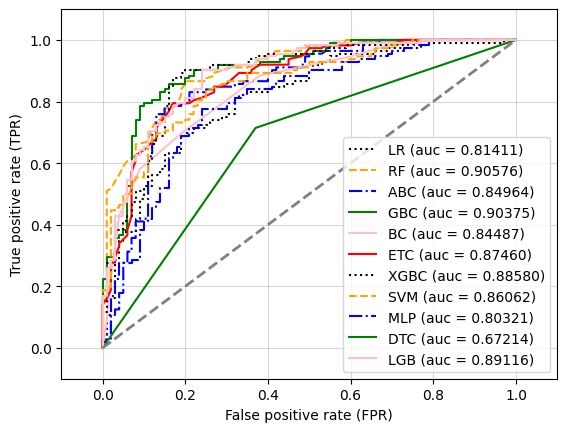

In [20]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

mlp = make_pipeline(StandardScaler(), MLPClassifier(hidden_layer_sizes=(200,), max_iter=10000))
lr = make_pipeline(StandardScaler(), LogisticRegression())
rf = RandomForestClassifier()
abc = AdaBoostClassifier()
gbc = GradientBoostingClassifier()
bc = BaggingClassifier()
etc = ExtraTreesClassifier()
xgbc = XGBClassifier()
svm = make_pipeline(StandardScaler(), SVC(probability=True))
dtc = DecisionTreeClassifier()
lgb = LGBMClassifier()

from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

all_clf=[lr, rf, abc, gbc, bc, etc, xgbc, svm, mlp,dtc, lgb]
clf_labels=["LR", "RF","ABC", "GBC", "BC","ETC","XGBC", "SVM","MLP","DTC", "LGB"]
colors =["black", "orange", "blue", "green","pink","red","black", "orange", "blue", "green","pink"]
linestyles = [":","--", "-.","-","-","-",":","--", "-.","-","-","-"]

for clf, label,clr,ls in zip(all_clf, clf_labels, colors, linestyles):
  y_pred= clf.fit(X_train,y_train2).predict_proba(X_test)[:,1]
  fpr,tpr,thresholds = roc_curve(y_test2, y_pred)
  roc_auc= auc(x=fpr, y=tpr)
  plt.plot(fpr, tpr, color=clr, linestyle=ls,
           label='%s (auc = %0.5f)' % (label, roc_auc))

plt.legend(loc='lower right')
plt.plot([0,1],[0,1],linestyle='--',color='gray',linewidth=2)
plt.xlim([-0.1,1.1])
plt.ylim([-0.1,1.1])
plt.grid(alpha=0.5)
plt.xlabel('False positive rate (FPR)')
plt.ylabel('True positive rate (TPR)')
plt.show()

# 1st RF

In [21]:
rf=RandomForestClassifier(random_state=SEED)

In [22]:
rf.fit(X_train.loc[:,Feature_doa],y_train2)
pred = rf.predict(X_test.loc[:,Feature_doa])
c_matrix = confusion_matrix(y_test2, pred)
c_report = classification_report(y_test2, pred)
c_matrix

array([[72, 28],
       [21, 91]])

In [23]:
print(c_report)

              precision    recall  f1-score   support

           0       0.77      0.72      0.75       100
           1       0.76      0.81      0.79       112

    accuracy                           0.77       212
   macro avg       0.77      0.77      0.77       212
weighted avg       0.77      0.77      0.77       212



# 4th step (2nd ML)

In [24]:
Z_train = X_train.loc[(y=='died')|(y=='euthanized')]
y2_train = y_train.loc[(y=='died')|(y=='euthanized')]

Z_test = X_test.loc[pred==1]
y2_test = y_test.loc[pred==1]

In [25]:
y2_train

345           died
137     euthanized
261           died
489           died
1154          died
           ...    
143           died
95      euthanized
769           died
906     euthanized
264           died
Name: outcome, Length: 446, dtype: object

In [26]:
y2_train2 = y2_train.replace('lived',0).replace('died',1).replace('euthanized',0)
y2_test2 = y2_test.replace('lived',0).replace('died',1).replace('euthanized',0)

/home/louise/.pyenv/versions/3.10.8/envs/e2project/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[LightGBM] [Info] Number of positive: 269, number of negative: 177
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000171 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 407
[LightGBM] [Info] Number of data points in the train set: 446, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.603139 -> initscore=0.418562
[LightGBM] [Info] Start training from score 0.418562
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

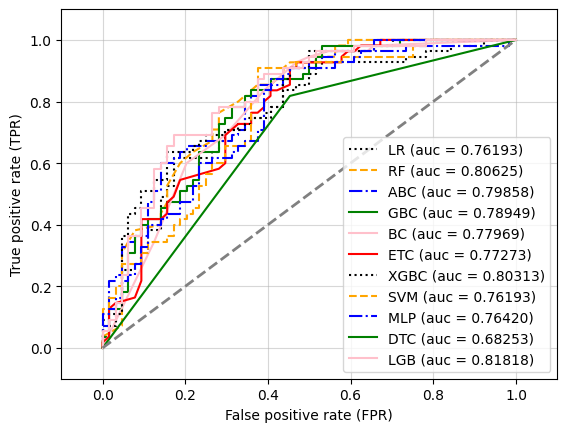

In [27]:
all_clf=[lr, rf, abc, gbc, bc, etc, xgbc, svm, mlp,dtc, lgb]
clf_labels=["LR", "RF","ABC", "GBC", "BC","ETC","XGBC", "SVM","MLP","DTC", "LGB"]
colors =["black", "orange", "blue", "green","pink","red","black", "orange", "blue", "green","pink"]
linestyles = [":","--", "-.","-","-","-",":","--", "-.","-","-","-"]

for clf, label,clr,ls in zip(all_clf, clf_labels, colors, linestyles):
  z_pred= clf.fit(Z_train,y2_train2).predict_proba(Z_test)[:,1]
  fpr,tpr,thresholds = roc_curve(y2_test2, z_pred)
  roc_auc= auc(x=fpr, y=tpr)
  plt.plot(fpr, tpr, color=clr, linestyle=ls,
           label='%s (auc = %0.5f)' % (label, roc_auc))

plt.legend(loc='lower right')
plt.plot([0,1],[0,1],linestyle='--',color='gray',linewidth=2)
plt.xlim([-0.1,1.1])
plt.ylim([-0.1,1.1])
plt.grid(alpha=0.5)
plt.xlabel('False positive rate (FPR)')
plt.ylabel('True positive rate (TPR)')
plt.show()

In [28]:
rf.fit(Z_train.loc[:,Feature_doe],y2_train2)
pred2 = rf.predict(Z_test.loc[:,Feature_doe])
c_matrix = confusion_matrix(y2_test2, pred2)
c_report = classification_report(y2_test2, pred2)
c_matrix

array([[34, 30],
       [ 5, 50]])

In [29]:
print(c_report)

              precision    recall  f1-score   support

           0       0.87      0.53      0.66        64
           1       0.62      0.91      0.74        55

    accuracy                           0.71       119
   macro avg       0.75      0.72      0.70       119
weighted avg       0.76      0.71      0.70       119



In [30]:
pred

array([1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0,
       0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1,
       1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1,
       1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1,
       0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0,
       1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0,
       1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0,
       1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1,
       0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0,
       0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1])

In [31]:
pred2

array([0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1,
       1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1,
       1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0,
       1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1,
       1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0,
       1, 0, 1, 1, 0, 0, 0, 0, 1])

In [32]:
first = pd.DataFrame(pred).replace(0,'lived')

In [33]:
second = pd.DataFrame(pred2).replace(1,'died')

In [34]:
first.shape, second.shape

((212, 1), (119, 1))

In [35]:
first

,0
0,1
1,1
2,lived
3,lived
4,lived
...,...
207,1
208,lived
209,lived
210,lived


In [36]:
PRED = first
PRED[PRED.iloc[:,0]==1] = second.values
PRED

,0
0,0
1,0
2,lived
3,lived
4,lived
...,...
207,0
208,lived
209,lived
210,lived


In [37]:
PRED = PRED.replace(0,'euthanized')
PRED

,0
0,euthanized
1,euthanized
2,lived
3,lived
4,lived
...,...
207,euthanized
208,lived
209,lived
210,lived


In [38]:
c_matrix = confusion_matrix(y_test, PRED)
c_report = classification_report(y_test, PRED)
c_matrix

array([[50,  5, 13],
       [10, 26,  8],
       [20,  8, 72]])

In [39]:
print(c_report)

              precision    recall  f1-score   support

        died       0.62      0.74      0.68        68
  euthanized       0.67      0.59      0.63        44
       lived       0.77      0.72      0.75       100

    accuracy                           0.70       212
   macro avg       0.69      0.68      0.68       212
weighted avg       0.70      0.70      0.70       212



# Prediction

In [40]:
test

,id,surgery,age,hospital_number,rectal_temp,pulse,respiratory_rate,temp_of_extremities,peripheral_pulse,mucous_membrane,...,abdomen,packed_cell_volume,total_protein,abdomo_appearance,abdomo_protein,surgical_lesion,lesion_1,lesion_2,lesion_3,cp_data
0,1235,0,0,534053,38.6,40.0,20.0,2,2,3,...,1,42.0,7.5,0,2.3,0,0,0,0,0
1,1236,1,0,528469,38.2,112.0,48.0,1,3,0,...,1,44.0,6.0,2,2.6,0,2208,0,0,1
2,1237,1,0,528178,37.7,66.0,12.0,1,2,1,...,1,31.5,6.0,1,1.6,1,2205,0,0,1
3,1238,0,0,534784,37.1,88.0,20.0,1,3,4,...,0,75.0,81.0,3,1.0,1,1400,0,0,0
4,1239,1,0,529840,38.3,50.0,12.0,4,2,0,...,1,37.0,6.8,1,2.6,1,2208,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
819,2054,0,0,529461,40.3,114.0,36.0,1,3,3,...,0,57.0,8.1,2,4.5,1,3205,0,0,1
820,2055,1,0,535338,37.2,100.0,20.0,1,3,4,...,1,50.0,66.0,2,2.0,1,2209,0,0,0
821,2056,1,0,529640,39.2,132.0,12.0,1,3,2,...,5,53.0,7.6,2,4.5,1,2205,0,0,0
822,2057,0,0,5287179,38.3,54.0,66.0,2,2,3,...,5,49.0,8.6,0,5.0,0,3111,0,0,1


In [41]:
Y = y.replace('lived',0).replace('died',1).replace('euthanized',1)
Y2 = y.replace('lived',0).replace('died',1).replace('euthanized',0)

In [42]:
rf.fit(X.loc[:,Feature_doa],Y)
pred_test = rf.predict(test.loc[:,Feature_doa])

In [43]:
rf.fit(X.loc[:,Feature_doe],Y2)
pred_test2 = rf.predict(test.loc[:,Feature_doe].loc[pred_test==1])

In [44]:
first = pd.DataFrame(pred_test).replace(0,'lived')
second = pd.DataFrame(pred_test2).replace(1,'died')
PRED_test = first
PRED_test[PRED_test.iloc[:,0]==1] = second.values
PRED_test = PRED_test.replace(0,'euthanized')
PRED_test

,0
0,lived
1,euthanized
2,lived
3,euthanized
4,lived
...,...
819,died
820,euthanized
821,died
822,lived


In [45]:
sample_submission

,id,outcome
0,1235,lived
1,1236,lived
2,1237,lived
3,1238,lived
4,1239,lived
...,...,...
819,2054,lived
820,2055,lived
821,2056,lived
822,2057,lived


In [46]:
sample_submission['outcome'] = PRED_test.iloc[:,0]
sample_submission

,id,outcome
0,1235,lived
1,1236,euthanized
2,1237,lived
3,1238,euthanized
4,1239,lived
...,...,...
819,2054,died
820,2055,euthanized
821,2056,died
822,2057,lived


In [47]:
# sample_submission.to_csv('submission.csv', index=False)

# Thanks for taking a look.
# 
# Good performance was not achieved.
# 
# If you have a two-step binary classification method, please let us know.